# Pipeline
1. 필요한 패키지 다운로드
- `ffmpeg` 다운받기 (자신의 OS에 맞게 다운받기)
- (pip 설치 가능) `yt-dlp` 패키지 다운 받기

2. `yt-dlp`로 url입력시 오디오와 비디오(오디오x)를 다운받을 수 있는 함수를 만들기

3. STT(Speech to Text) 함수 (OpenAI Whisper API) 개발 (전사)

4. Topic Segmentation (하나의 긴 텍스트 -> 주제별로 쪼갠다) OpenAI GPT4 API

5. Image Extraction

6. 주제별로 요약 생성 (Image + Text) -> OpenAI GPT-4V API -> 요약문

# 1. 필요한 패키지 다운로드
- `ffmpeg`
- `yt-dlp`

In [2]:
!pip install yt-dlp


[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: pip install --upgrade pip


# 2. Youtube URL에서 오디오 비디오 다운로드

In [3]:
import os
import yt_dlp

In [4]:
youtube_source = "https://youtu.be/QMnKZYX39Aw?si=NcW-eQoqJkncTij-" # JinCoding example Youtube
output_path = "./data/raw_data/"
os.makedirs(output_path, exist_ok=True) # 폴더 생성

def download_youtube_rsc(youtube_url, output_path):
    
    audio_params = {
        'format' : 'bestaudio/best', # format: m4a
        'outtmpl' : output_path + 'audio.m4a'
    }
    
    video_params = {
        'format' : 'bestvideo/best', # format: mp4
        'outtmpl' : output_path + 'video.mp4'
    }
    
    # 주석:cntrl + "/"
    with yt_dlp.YoutubeDL(audio_params) as ydl:
        ydl.download([youtube_source])
    print("Audio file download success!")
    
    with yt_dlp.YoutubeDL(video_params) as ydl:
        ydl.download([youtube_source])
    print("Video file download success!")

In [5]:
download_youtube_rsc(youtube_url=youtube_source, output_path=output_path)

[youtube] Extracting URL: https://youtu.be/QMnKZYX39Aw?si=NcW-eQoqJkncTij-
[youtube] QMnKZYX39Aw: Downloading webpage
[youtube] QMnKZYX39Aw: Downloading ios player API JSON
[youtube] QMnKZYX39Aw: Downloading android player API JSON


[youtube] QMnKZYX39Aw: Downloading player d8a5aa5e
[youtube] QMnKZYX39Aw: Downloading m3u8 information
[info] QMnKZYX39Aw: Downloading 1 format(s): 251
[download] Destination: ./data/raw_data/audio.m4a
[download] 100% of    4.71MiB in 00:00:00 at 20.20MiB/s  
Audio file download success!
[youtube] Extracting URL: https://youtu.be/QMnKZYX39Aw?si=NcW-eQoqJkncTij-
[youtube] QMnKZYX39Aw: Downloading webpage
[youtube] QMnKZYX39Aw: Downloading ios player API JSON
[youtube] QMnKZYX39Aw: Downloading android player API JSON
[youtube] QMnKZYX39Aw: Downloading m3u8 information
[info] QMnKZYX39Aw: Downloading 1 format(s): 248
[download] Destination: ./data/raw_data/video.mp4
[download] 100% of   24.02MiB in 00:00:00 at 25.08MiB/s    
Video file download success!


# 3. STT (전사)
- Whisper API 사용해서 STT 실행

In [6]:
from openai import OpenAI

In [7]:
client = OpenAI(api_key=os.environ.get("OPENAI_API_KEY", ""))

In [8]:
audio_file = open(output_path + 'audio.m4a', 'rb')

In [9]:
transcript = client.audio.transcriptions.create(
    file = audio_file,
    model = "whisper-1",
    response_format="verbose_json",  # audio -> text **timestamp** data를 얻을 수 있음
    timestamp_granularities=["segment"] # 어느 정도까지 미세하게 할 것인지 결정 (segment 가 가장 작은 크기임)
)

In [12]:
transcript.segments

[{'id': 0,
  'seek': 0,
  'start': 0.0,
  'end': 5.28000020980835,
  'text': ' 안녕하세요 많은 분들이 저한테 어 개발자로 영어 어떻게 배워요 물어보셨죠',
  'tokens': [50364,
   19289,
   18494,
   36029,
   4841,
   15863,
   9076,
   30185,
   17248,
   11945,
   1955,
   9293,
   3103,
   12952,
   14155,
   35837,
   44558,
   20107,
   227,
   101,
   5837,
   50628],
  'temperature': 0.0,
  'avg_logprob': -0.2964220941066742,
  'compression_ratio': 1.6637167930603027,
  'no_speech_prob': 0.0066683595068752766},
 {'id': 1,
  'seek': 0,
  'start': 5.28000020980835,
  'end': 12.880000114440918,
  'text': ' 이제 최쥐피치에서 보이스 기능이 생겨서 마치 영어 허에 삼한자와 얘기하듯이 얘기할 수 있는 기능이 생겼어요',
  'tokens': [50628,
   8424,
   14571,
   168,
   98,
   238,
   20701,
   8464,
   4885,
   6330,
   28334,
   7047,
   16102,
   1129,
   6439,
   19591,
   2393,
   6437,
   8464,
   9293,
   3103,
   26893,
   1517,
   32391,
   3049,
   4264,
   7590,
   19641,
   8037,
   39358,
   1129,
   19641,
   7999,
   4446,
   7153,
   7047,
   16102,
   

In [13]:
# 필요 없는 key 지우기
erase_keys = ['id', 'seek', 'tokens', 'temperature', 'avg_logprob', 'compression_ratio', 'no_speech_prob']
for seg in transcript.segments:
    for ekey in erase_keys:
        del seg[ekey]

In [14]:
transcript.segments

[{'start': 0.0,
  'end': 5.28000020980835,
  'text': ' 안녕하세요 많은 분들이 저한테 어 개발자로 영어 어떻게 배워요 물어보셨죠'},
 {'start': 5.28000020980835,
  'end': 12.880000114440918,
  'text': ' 이제 최쥐피치에서 보이스 기능이 생겨서 마치 영어 허에 삼한자와 얘기하듯이 얘기할 수 있는 기능이 생겼어요'},
 {'start': 12.880000114440918,
  'end': 20.15999984741211,
  'text': ' 그래서 제가 몇 주 전부터 써보고 아 이렇게 쓰면 딱 맞다라는 걸 여러분들한테 알려드리려고 오늘 갖고 왔어요'},
 {'start': 20.15999984741211,
  'end': 23.760000228881836,
  'text': ' 최쥐피치로 영어 학습을 하는데 가장 좋은 점은요'},
 {'start': 23.760000228881836,
  'end': 29.1200008392334,
  'text': ' 여러분들이 원하는 학습 목적에 맞게 그리고 여러분들의 상황에 맞게끔'},
 {'start': 29.1200008392334,
  'end': 32.47999954223633,
  'text': ' Personalized 즉 초개인화가 가능하다는 거예요'},
 {'start': 32.47999954223633,
  'end': 37.279998779296875,
  'text': ' 다른 회화들은 나한테 100%로 맞춤형으로 할 수가 없거든요'},
 {'start': 37.279998779296875,
  'end': 45.119998931884766,
  'text': ' 그런데 최쥐피치는 우리가 처음에 프롬프트만 잘 얘기를 해주면은 나한테 딱 맞는 영어 회화 선생님이 될 수 있는 거예요'},
 {'start': 45.119998931884766,
  'end': 47.68000030517578,
  'text': 

# 4. Topic Segmentation (GPT-4-turbo)
- 긴 텍스트를 비슷한 "문맥(topic)"을 기준으로 여러개의 text segment로 분리 ("Paragraph Splitting", "Text Segmentation")
- Segment의 시작과 종료 timestamp 정보를 반환

In [15]:
def run_gpt(model:str, messages:list, max_token:int=150, temperature:float=0.7, is_json:bool=False, seed:int=None, tools:list=None, tool_choice:str=None, stream:bool=False):

    response = client.chat.completions.create(
        model=model,
        messages=messages,
        max_tokens=max_token,
        temperature=temperature,
        response_format = {'type' : 'json_object'} if is_json else {'type' : 'text'},
        seed=seed,
        tools=tools,
        tool_choice="auto" if tools else tool_choice,
        stream=stream
    )
    
    return response

In [21]:
text_segment = transcript.segments
topic_num = 3

# Json Format 정의 {'0' : {'start' : {start timestamp}, 'end' : {end timestamp}}, ...}
system_message = "Json Format: {'0' : {'start' : {start timestamp}, 'end' : {end timestamp}}, ...}" 
user_message = f"""
삼중 따옴표 안에 영상의 대본 텍스트가 리스트 형태로 담겨있어.
텍스트를 보고 문맥적으로 유사한 하위 텍스트 그룹 {topic_num}개가 생성될 수 있도록 topic segmentation 을 진행해줘.
텍스트 그룹은 반드시 비슷한 문맥 또는 하나의 주제로 묶어야 해.
또한 텍스트 그룹간에 겹치는 부분이 없어야 해.
텍스트 그룹을 분리한 후에는 그룹의 시작과 끝 timestmap를 제공된 JSON Format으로 반환해줘.
JSON Format의 key에는 텍스트 그룹의 인덱스가, value에는 JSON이 들어가야 해.
Value Json은 'stat' key에 텍스트 그룹의 시작 timestamp가, 'end' key에 텍스트 그룹의 종료 timestamp 를 넣어줘야 해.

\"\"\"{text_segment}\"\"\"
"""



# system_message = "너는 유능한 비서야. JSON Format: {0: {'start': 'start timestamp', 'end': 'end timestamp'}), {0: {'start': 'start timestamp', 'end': 'end timestamp'}), ...}" 
# user_message = f"""
# 삼중 따옴표 안에 json array 형태로 구분된 데이터를 줄게. 조건에 맞춰 다음을 수행해줘.

# 조건:
# 1. 문맥적으로 유사한 하위 텍스트 그룹 {topic_num}개가 생성될 수 있도록 topic segmentation 을 진행해줘.
# 2. 텍스트 그룹 간 겹치는 부분이 존재하면 안돼
# 3. 텍스트 그룹 분리 후에는 그룹의 시작과 끝 timestamp를 제공된 JSON Format 형식으로 반환해줘.

# 결과물은 다음의 JSON FORMAT을 따라 작성해줘. Json의 key에는 인덱스를 적어주고, valeu 에는 json 을 적어줘.
# value json은 첫번째 key에는 'start'를 적고 value에는 분리된 topic segment의 start timestamp를 넣어주고, 두번째 Key에는 'end'를 적고 value에는 분리된 topic segment의 end timestamp를 넣어줘.

# \"\"\"{text_segment}\"\"\"
# """




# text_segment를 제공
# 조건1: 문맥적으로 유사한 하위 텍스트 그룹 {topic_num}개 생성될 수 있도록 topic segmentation 진행
# 조건2: 텍스트 그룹 간 겹치는 부분이 존재하면 안됨
# 조건3: 텍스트 그룹 분리 후에는 그룹의 시작과 끝 timestamp를 제공된 JSON Format 형식으로 반환
# 형식: JSON Format의 key에는 텍스트 그룹의 인덱스가 value에는 json이 들어감. Value Json은 'start' key에 텍스트 그룹의 시작 timestamp가, 'end' key에 텍스트 그룹의 종료 timestamp가 들어감

model = "gpt-4-turbo"
max_token = 3000
messages = [
    {"role": "system", "content": system_message},
    {"role": "user", "content": user_message}
]

In [22]:
response = run_gpt(model, messages, max_token, is_json=True, temperature=0.1, seed=100)

In [23]:
import json

In [24]:
output = json.loads(response.choices[0].message.content)

In [25]:
output

{'0': {'start': 0.0, 'end': 53.84000015258789},
 '1': {'start': 59.84000015258789, 'end': 241.0399932861328},
 '2': {'start': 244.0, 'end': 385.2799987792969}}

# 5. Image Extraction
- output을 이용해서 text_segment를 주제로 분리하기. ```[{},{},{}] -> [[{},{},{}],[{},{},{}],[{},{},{}]]```
- topic마다 image frame 3개 추출해서 이미지들을 폴더에 저장하기

In [26]:
import subprocess
import os

In [27]:
# 2.0 -> 00:00:02
def seconds2hms(x):
    total_seconds = int(x)
    hours, remainder = divmod(total_seconds,3600)
    minutes, seconds = divmod(remainder, 60)

    time_format = "{:02}:{:02}:{:02}".format(hours, minutes, seconds) # 5 -> 05

    return time_format

In [28]:
number_pic_per_topic = 3
paragraphs = []

for i, timestamp_item in enumerate(output.values()):
    s, e = timestamp_item['start'], timestamp_item['end']
    # split topic
    ADD_FLAG = False
    for segment in text_segment:
        if segment['start'] == s: # 새로운 topic list를 생성
            paragraphs.append([])
            ADD_FLAG = True
        if ADD_FLAG:
            paragraphs[-1].append(segment) # segment를 topic list에 담기

        if segment['end'] == e:
            break # for loop 종료

    # topic에서 이미지 추출해서 저장
    # frame per second: 초당 프레임 개수
    start_time = seconds2hms(s)
    end_time = seconds2hms(e)
    video_path = os.path.join(output_path,"video.mp4")
    fps_ratio = number_pic_per_topic / (e-s)
    cur_img_dir = f"./data/topic{i}"
    os.makedirs(cur_img_dir, exist_ok=True) # 폴더 생성

    # 동영상에서 프레임 별 이미지 생성
    command = f"ffmpeg -ss {start_time} -to {end_time} -i '{video_path}' -vf 'fps={fps_ratio}' '{cur_img_dir}/output%d.png'"
    subprocess.run(command, shell=True)
            

ffmpeg version 6.1.1-tessus  https://evermeet.cx/ffmpeg/  Copyright (c) 2000-2023 the FFmpeg developers
  built with Apple clang version 11.0.0 (clang-1100.0.33.17)
  configuration: --cc=/usr/bin/clang --prefix=/opt/ffmpeg --extra-version=tessus --enable-avisynth --enable-fontconfig --enable-gpl --enable-libaom --enable-libass --enable-libbluray --enable-libdav1d --enable-libfreetype --enable-libgsm --enable-libmodplug --enable-libmp3lame --enable-libmysofa --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenh264 --enable-libopenjpeg --enable-libopus --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvmaf --enable-libvo-amrwbenc --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxavs --enable-libxml2 --enable-libxvid --enable-libzimg --enable-libzmq --enable-libzvbi --enable-version3 --pkg-config-flags=--stat

In [30]:
len(paragraphs)

3

In [29]:
paragraphs[0]

[{'start': 0.0,
  'end': 5.28000020980835,
  'text': ' 안녕하세요 많은 분들이 저한테 어 개발자로 영어 어떻게 배워요 물어보셨죠'},
 {'start': 5.28000020980835,
  'end': 12.880000114440918,
  'text': ' 이제 최쥐피치에서 보이스 기능이 생겨서 마치 영어 허에 삼한자와 얘기하듯이 얘기할 수 있는 기능이 생겼어요'},
 {'start': 12.880000114440918,
  'end': 20.15999984741211,
  'text': ' 그래서 제가 몇 주 전부터 써보고 아 이렇게 쓰면 딱 맞다라는 걸 여러분들한테 알려드리려고 오늘 갖고 왔어요'},
 {'start': 20.15999984741211,
  'end': 23.760000228881836,
  'text': ' 최쥐피치로 영어 학습을 하는데 가장 좋은 점은요'},
 {'start': 23.760000228881836,
  'end': 29.1200008392334,
  'text': ' 여러분들이 원하는 학습 목적에 맞게 그리고 여러분들의 상황에 맞게끔'},
 {'start': 29.1200008392334,
  'end': 32.47999954223633,
  'text': ' Personalized 즉 초개인화가 가능하다는 거예요'},
 {'start': 32.47999954223633,
  'end': 37.279998779296875,
  'text': ' 다른 회화들은 나한테 100%로 맞춤형으로 할 수가 없거든요'},
 {'start': 37.279998779296875,
  'end': 45.119998931884766,
  'text': ' 그런데 최쥐피치는 우리가 처음에 프롬프트만 잘 얘기를 해주면은 나한테 딱 맞는 영어 회화 선생님이 될 수 있는 거예요'},
 {'start': 45.119998931884766,
  'end': 47.68000030517578,
  'text': 

# 6. GPT-4V 영상 요약하기
1. 3가지 이미지 중에서 topic 대표할 수 있는 이미지 추출
2. 이미지 + 텍스트를 바탕으로 요약

In [31]:
import base64

In [61]:
def encode_image(image_path):
    with open(image_path, 'rb') as image_file:
        image_base64 = base64.b64encode(image_file.read()) # binary data -> base64 string 변환
    return image_base64.decode('utf-8')

In [62]:
# image_output 리스트에 첫번째 topic segment에 해당하는 이미지 3개를 string으로 인코딩한 후 append
topic_idx = 0
cur_dir = f"./data/topic{topic_idx}"
image_outputs = []
for file_name in os.listdir(cur_dir):
    if file_name.endswith(".png"):
        encoded_image = encode_image(os.path.join(cur_dir, file_name))
        image_outputs.append({"type" : "image_url", "image_url" : {"url" : "data:image/png;base64,"+encoded_image}})

In [63]:
transcription = "".join([item["text"] for item in paragraphs[topic_idx]])

# 비디오 분석가라는 페르소나 제공. Json Format 정의 {\"image index\" : {image index number}, \"summary\" : {summary text}}
system_message = """
너는 비디오의 대본과 이미지를 보고 핵심을 요약하는 비서야. Json Format: {"image index" : {image index number}, "summary" : {summary text}}
"""

user_message = f"""
삼중 따옴표 안에 비디오의 특정 구간의 대본 텍스트를 제공할.
메시지에 비디오에서 구간 별로 추출한 3개의 썸네일 이미지를 보고 입력된 순서대로 0부터 시작해서 순차적으로 이미지 인덱스를 생성해줘.
먼저, 비디오의 주제를 가장 잘 설명하는 이미지를 선택하고 이미지 인덱스 번호를 반환해줘.
다음으로, 비디오의 전체 맥락을 가장 잘 설명하는 요약본을 작성해줘. 요약은 한국어로 작성하되, 대본에서 중용한 정보는 모두 포함해줘.
그리고 요약본에는 반드시 대표 이미지에 대한 설명도 포함시켜줘.

\"\"\"{transcription}\"\"\"
"""

# user_message = f"""
# 삼중 따옴표에 대본 텍스트를 제공할거야.
# 아래 조건에 맞춰서 요약해줘.

# 조건:
# 1. 제공된 이미지는 입력 순서대로 0부터 시작하는 인덱스를 생성
# 2. 비디오를 가장 잘 표현하는 이미지 1개를 선택한 후 그 인덱스 반환
# 3. 비디오 요약 1~2 문장으로 생성. 요약은 한국어로 그리고 대본의 중요 정보 모두 포함

# \"\"\"{transcription}\"\"\"
# """

# 비디오에서 추출한 3개의 썸네일 이미지와 대본 텍스트를 제공함
# 조건1: 제공된 이미지는 입력 순서대로 0부터 시작하는 인덱스를 생성
# 조건2: 비디오를 가장 잘 표현하는 이미지 1개를 선택한 후 그 인덱스 반환
# 조건3: 비디오 요약 1~2 문장으로 생성. 요약은 한국어로 그리고 대본의 중요 정보 모두 포함

model = "gpt-4-turbo"
max_token = 2000
messages = [
    {"role": "system", "content": system_message},
    {"role": "user", "content": [{"type" : "text", "text" : user_message}] + image_outputs}
]

In [64]:
response = run_gpt(model, messages, max_token, is_json=True)

In [65]:
res = json.loads(response.choices[0].message.content)
res

{'image index': 1,
 'summary': "이 비디오는 '최쥐피치'라는 도구를 사용하여 영어를 학습하는 방법에 대해 설명하고 있습니다. 발표자는 최쥐피치의 보이스 기능이 실제 영어 환경처럼 대화할 수 있게 해주며, 사용자의 필요와 상황에 맞춰 개인화된 학습이 가능하다는 점을 강조합니다. 특히, 사용자가 원하는 학습 목적에 따라 맞춤형 대화를 설정할 수 있는 점을 장점으로 언급합니다. 대표 이미지(인덱스 1)는 발표자가 카메라를 향해 이야기하는 모습을 담고 있으며, 이는 비디오의 주제를 잘 나타내고 있습니다."}

In [66]:
from IPython.display import display, HTML

In [67]:
selected_img_url = image_outputs[res['image index']]['image_url']['url']


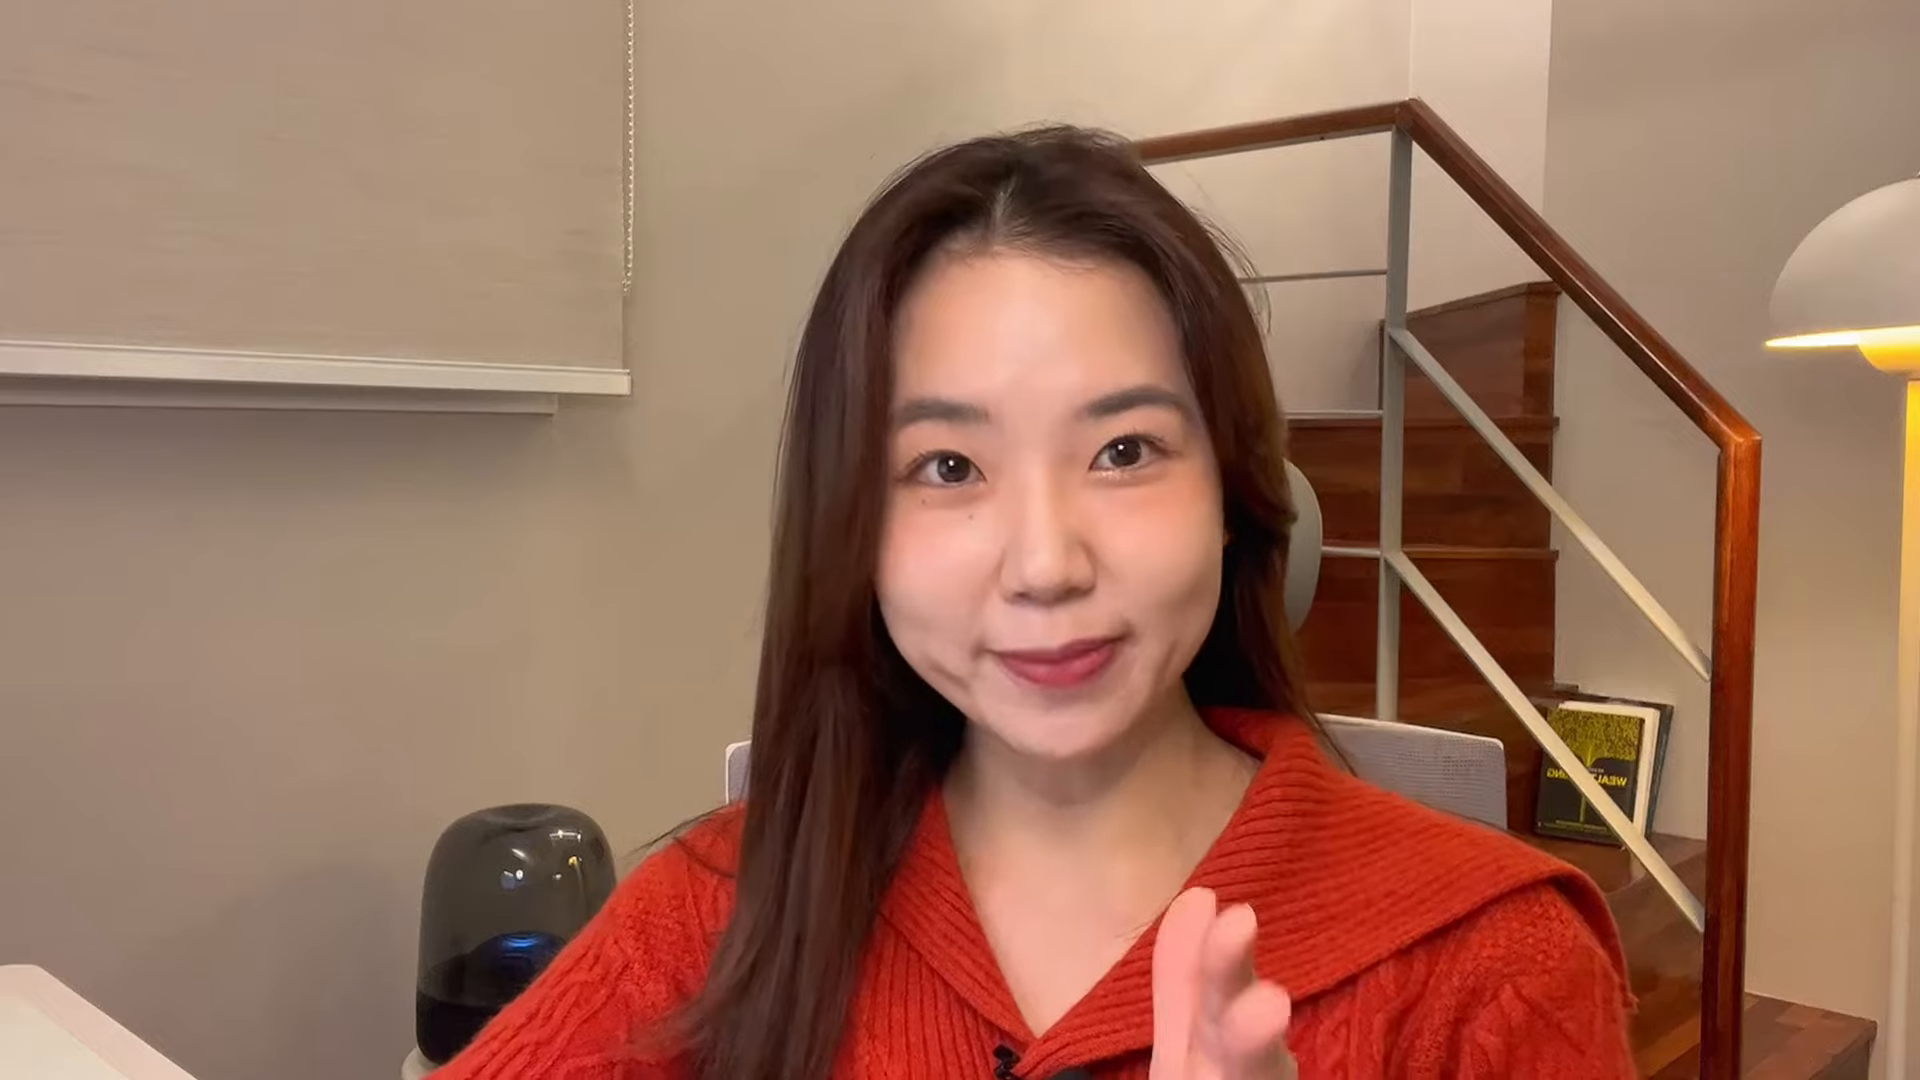

In [68]:
image_html = f'<img src="{selected_img_url}"/>'
display(HTML(image_html))